# Imports and configs

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import warnings
from sklearn import metrics

In [3]:
pd.options.plotting.backend = "plotly"

In [4]:
data_path = "https://storage.googleapis.com/edulabs-public-datasets/callcenter.csv"

# Load the data

In [5]:
df = pd.read_csv(data_path, parse_dates=['QueueStartDate'], dayfirst=True)

In [ ]:
df.head()

,QueueStartDate,QueueStartDateName,Interval,CallTypeName,CallsOffered,CallsAnswered,CallsAbonded,CallbackRequest,CallsTransfered,WaitDuration,...,CallDuration,MaxCallDuration,AvgCallDuration,P_CallsAnswered,P_CallsAbonded,P_CallsTransfered,P_CallbackRequest,TotalAgents,TotalSupervisors,TotalAgentsAndSupervisors
0,2024-01-01,Monday,08:00 - 08:30,HdKamuti,2,1,1,0,0,933,...,116,116,116,50.00,50.00,0.0,0.00,36.0,2.0,38.0
1,2024-01-01,Monday,08:00 - 08:30,ShlihimCB,7,6,1,0,0,414,...,1029,503,171,85.71,14.29,0.0,0.00,36.0,2.0,38.0
2,2024-01-01,Monday,08:30 - 09:00,HouseDelivery,6,5,0,1,0,83,...,596,283,99,100.00,0.00,0.0,16.67,42.0,2.0,44.0
3,2024-01-01,Monday,08:30 - 09:00,SuperVisor_L,6,5,1,0,0,149,...,1428,435,285,83.33,16.67,0.0,0.00,42.0,2.0,44.0
4,2024-01-01,Monday,09:00 - 09:30,Appointments,58,41,7,10,0,14956,...,3401,181,66,87.93,12.07,0.0,17.24,44.0,3.0,47.0


# Preprocess the data

- Create a pandas series with date index, series should contain one element (row) per total callsOffered per day
- We are going to analyze and later predict amount of calls per day


In [9]:
ts = df[['QueueStartDate', 'CallsOffered']].set_index('QueueStartDate').squeeze().groupby(pd.Grouper(freq='D')).sum()

In [ ]:
#ts.reset_index()["QueueStartDate"].dt.isocalendar().week

# Data visualization

Display various plots and try to determine the following:
- Does data have structure or it looks like white noise / random walk
- Is there a trend in data?
- Is there seasonality?

Try the following plots:
- Lines
- Histograms
- Boxes
- Heat maps
- Other

In [ ]:
ts.plot()

In [ ]:
px.box(ts, color=ts.index.day_name())

In [ ]:
px.box(ts, color=ts.index.month_name())

# Is data stationary?

**Determine whether your data is stationary, and if not - remove trends / seasonalities**

1. Run ADF test to find whther your data is stationary
2. If the data is not stationary - use differencing techniques to remove trend and seasonality
3. Run ADF test again after performing differencing to see whether data is stationary.
4. Run steps 2-3 again if needed

In [ ]:
# Run ADF test
result = adfuller(ts)

# Display results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -3.193718023210919
p-value: 0.02035119645709602
Critical Value (1%): -3.44911857009962
Critical Value (5%): -2.8698097654570507
Critical Value (10%): -2.5711757061225153


In [ ]:
# lets try and remove seasonality (weekly)
ts.diff(7).dropna().plot()

The data looks quite stationary with some anomalies
- the drops in calls might indicate holidays (we can axtually double-check it with hebrew calendar)
- the peaks need to be explained

In [ ]:
# prompt: get israel public holidays in 2024

import holidays

il_holidays = holidays.Israel(years=2024)

for date, name in sorted(il_holidays.items()):
    print(date, name)


2024-04-23 Pesach
2024-04-29 Seventh day of Pesach
2024-05-14 Independence Day (observed)
2024-06-12 Shavuot
2024-10-03 Rosh Hashanah
2024-10-04 Rosh Hashanah
2024-10-12 Yom Kippur
2024-10-17 Sukkot
2024-10-24 Simchat Torah / Shemini Atzeret


In [ ]:
# Run ADF test
result = adfuller(ts.diff(7).dropna())

# Display results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -6.465515040688818
p-value: 1.4085013334427812e-08
Critical Value (1%): -3.4495033946549123
Critical Value (5%): -2.8699787979596136
Critical Value (10%): -2.5712658305164955


In [ ]:
detrended = ts.diff(7).dropna()

In [ ]:
px.box(detrended, color=detrended.index.month_name())

# Now, after the data is stationary - check whether it's white noise (can it be forecasted at all?)

- Display ACF plot and check for auto-correlation
- Run Ljung-Box Test


Reminder:
**Autocorrelation Plot (ACF)**
- If no significant autocorrelation at any lag → likely white noise.
- If significant autocorrelation at lag 1 or others → likely AR process (i.e., a differenced random walk).

**Ljung-Box Test**
- A high p-value → series are like white noise
- A low p-value → autocorrelation exists - not a white noise


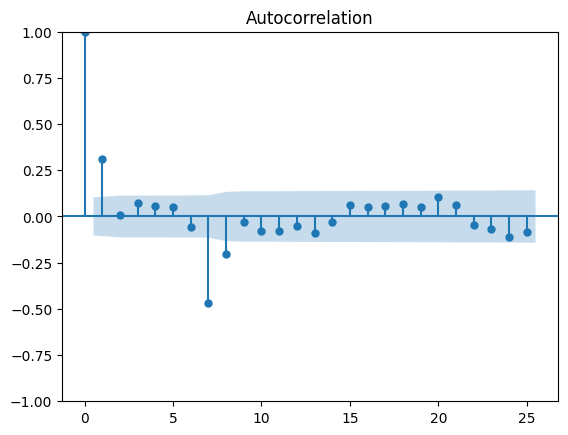

In [ ]:
plot_acf(detrended, lags=25) # Adjust lags as needed
plt.show()

We can clearly see autogorrelation with 1 lag

In [ ]:
lb_test = acorr_ljungbox(detrended, lags=10, return_df=True)
print(lb_test)

       lb_stat     lb_pvalue
1    34.904206  3.463318e-09
2    34.925773  2.605942e-08
3    36.953142  4.707625e-08
4    38.193832  1.021984e-07
5    39.255928  2.109156e-07
6    40.560929  3.533428e-07
7   120.361030  6.443320e-23
8   135.190265  2.370364e-25
9   135.581383  8.413827e-25
10  137.948613  1.108982e-24


The data is not a noise by all means and we should be able to forecast it

# **Adding test data**

- Our train data is daily callsOffered for 2024 (01-01-2024 -> 31-12-2024)
- Now we added data for 2025 (01-01-2025 -> 14-01-2025)
- You are going to train your models on data from 2024, select best params using cross-validation, abd in the end you will perform final test on the data for 2025

In [ ]:
test_data_path = "https://storage.googleapis.com/edulabs-public-datasets/callcenter2025.csv"

In [ ]:
test_ts = pd.read_csv(test_data_path, parse_dates=['QueueStartDate'], dayfirst=True)[['QueueStartDate', 'CallsOfferes']].set_index('QueueStartDate').squeeze()

#**Forecasting with SARIMAX**

- find SARIMAX parameters p,d,q and seasonal P,D,Q,s
- perform grid search if needed for parameter tuning
- plot actual vs predicted values for 1 week (first week of 2025) with built-in recursive forecast
- Implement rolling forecast (online training). This time you can only retrain new model every 3 days. In other words, you train the model, then you use this model to forecast upcoming 3 days, then you receive the actual data for these 3 days, and now you can retrain the model with actual data and make predictions for upcoming 3 days again
- Use test set of 2025, run the 3-days rolling forecast on the test data, calculate the predictions for the whole period
- Plot actual vs predicted values for 2025
- Calculate MAE, MAPE, MSE for this test data

In [ ]:
d = 0

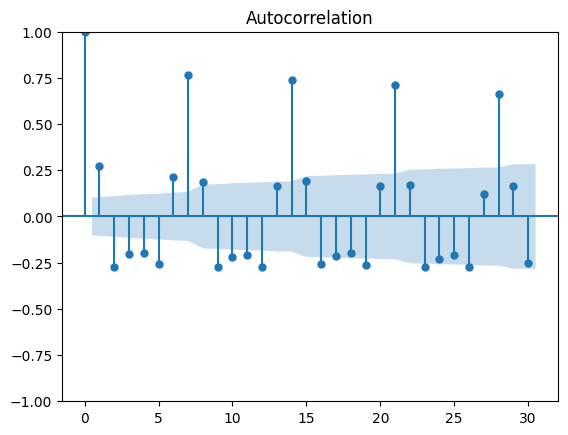

In [ ]:
plot_acf(ts, lags=30).show()

In [ ]:
q = 2 # or 1?


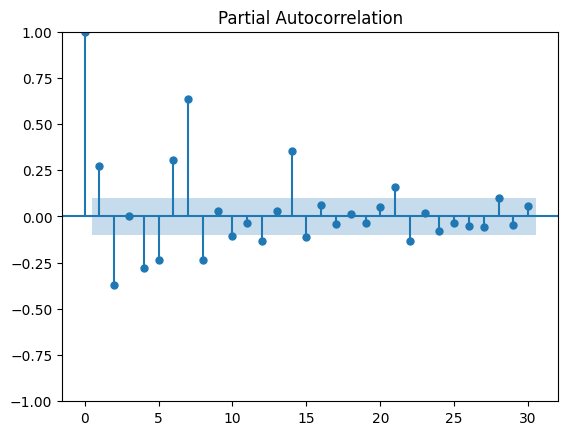

In [ ]:
plot_pacf(ts, lags=30).show()

In [ ]:
p = 2 # or 1?

In [ ]:
tss = ts.diff(7).dropna()

In [ ]:
tss.plot()

In [ ]:
D = 1

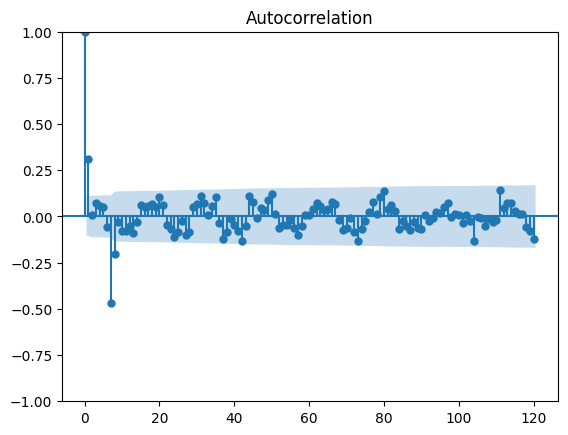

In [ ]:
plot_acf(tss, lags=120).show()

In [ ]:
Q = 1 # or 0

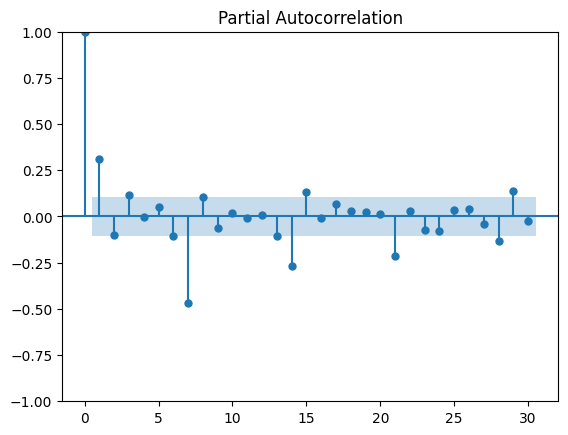

In [ ]:
plot_pacf(tss, lags=30).show()

### SARIMAX params

In [121]:
p = 2 # 1
d = 0
q = 1 # 1

P = 1
D = 1
Q = 1
s = 7

### Try training SARIMAX

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(ts, order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        CallsOffered   No. Observations:                  366
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood               -3264.892
Date:                             Sun, 18 May 2025   AIC                           6543.783
Time:                                     08:22:25   BIC                           6570.967
Sample:                                 01-01-2024   HQIC                          6554.593
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8179      0.155      5.288      0.000       0.515       1.121
ar.L2          0.1373      

In [8]:
# though we are quite sure about our parameters, lets try grid search
# we'll try maybo only seasonal params - P, Q

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import warnings
from sklearn import metrics
warnings.filterwarnings("ignore")



# Candidate parameters
p_values = [1, 2]
q_values = [1, 2]
Q_values = [0, 1]

# CV Setup
tscv = TimeSeriesSplit(n_splits=5, test_size=3)

# Search
best_score = float("inf")
best_order = None

for P in p_values:
    for q in q_values:
        for Q in Q_values:
            mae_list = []
            for train_idx, test_idx in tscv.split(ts):
                train_cv, test_cv = ts.iloc[train_idx], ts.iloc[test_idx]
                try:
                    model = SARIMAX(train_cv, order=(p, d, q), seasonal_order=(P,D,Q,s)).fit()
                    forecast = model.forecast(steps=len(test_cv))
                    mae = metrics.mean_absolute_error(test_cv, forecast)
                    mae_list.append(mae)
                except:
                    break  # Skip failed models
            if len(mae_list) == tscv.get_n_splits():
                avg_mae = np.mean(mae_list)
                print(f"SARIMAX({P},{D},{Q}) MAE = {avg_mae:.2f}")
                if avg_mae < best_score:
                    best_score = avg_mae
                    best_order = (P, D, Q)

print(f"\n✅ Best order: SARIMAX{best_order} with average MAE = {best_score:.2f}")


SARIMAX(1,1,0) MAE = 2179.53
SARIMAX(1,1,1) MAE = 2783.18
SARIMAX(1,1,0) MAE = 2198.01
SARIMAX(1,1,1) MAE = 2688.54
SARIMAX(2,1,0) MAE = 2168.04
SARIMAX(2,1,1) MAE = 2579.22
SARIMAX(2,1,0) MAE = 2223.74
SARIMAX(2,1,1) MAE = 2420.02

✅ Best order: SARIMAX(2, 1, 0) with average MAE = 2168.038


The errors are huge, SARIMAX cannot model well all the holidays

### It looks like holiday anomalies are too high for SARIMAX to be fit

We'll try removing holidays as anomalies

In [277]:
ts_copy = ts.copy()

In [268]:
ts.plot()

In [244]:
ts_diff = ts_copy.diff(7)

In [245]:
anomalies = np.abs(ts_diff) > 5000

In [246]:
ts_diff_clean = ts_diff.copy()
ts_diff_clean[anomalies] = np.nan
ts_diff_clean = ts_diff_clean.interpolate(method='linear')

In [247]:
ts_diff_clean.plot()

In [248]:
ts_copy.iloc[7:] = ts_copy.iloc[:-7].values + ts_diff_clean.iloc[7:].values

In [257]:
ts_diff_clean.loc['2024-06-11':'2024-06-13']

,CallsOffered
QueueStartDate,
2024-06-11,1572.0
2024-06-12,2817.0
2024-06-13,4062.0


In [258]:
ts.loc['2024-06-04':'2024-06-06']

,CallsOffered
QueueStartDate,
2024-06-04,11088
2024-06-05,10515
2024-06-06,10288


In [260]:
ts_copy.loc['2024-06'].plot()

In [259]:
ts.loc['2024-06'].plot()

In [261]:
ts_diff.loc['2024-06'].plot()

In [254]:
ts_diff.loc['2024-06']

,CallsOffered
QueueStartDate,
2024-06-01,0.0
2024-06-02,1150.0
2024-06-03,7.0
2024-06-04,-893.0
2024-06-05,-945.0
2024-06-06,-779.0
2024-06-07,154.0
2024-06-08,0.0
2024-06-09,-187.0


In [252]:
ts.diff(7).plot()

In [251]:
ts_copy.diff(7).plot()

We can clearly see that we were not able to smooth all the holidays using this procee, however we still expect improvement in error rates

In [249]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(ts_copy, order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       CallsOffered   No. Observations:                  366
Model:             SARIMAX(2, 0, 1)x(1, 1, [], 7)   Log Likelihood               -3307.301
Date:                            Sun, 18 May 2025   AIC                           6624.603
Time:                                    09:35:59   BIC                           6644.020
Sample:                                01-01-2024   HQIC                          6632.324
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0339      0.818     -0.041      0.967      -1.636       1.569
ar.L2          0.0946      0.337   

In [250]:
# though we are quite sure about our parameters, lets try grid search
# we'll try maybo only seasonal params - P, Q

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import warnings
from sklearn import metrics
warnings.filterwarnings("ignore")



# Candidate parameters
p_values = [1]
q_values = [1]
Q_values = [0]

# CV Setup
tscv = TimeSeriesSplit(n_splits=5, test_size=3)

# Search
best_score = float("inf")
best_order = None

for P in p_values:
    for q in q_values:
        for Q in Q_values:
            mae_list = []
            for train_idx, test_idx in tscv.split(ts_copy):
                train_cv, test_cv = ts_copy.iloc[train_idx], ts_copy.iloc[test_idx]
                try:
                    model = SARIMAX(train_cv, order=(p, d, q), seasonal_order=(P,D,Q,s)).fit()
                    forecast = model.forecast(steps=len(test_cv))
                    mae = metrics.mean_absolute_error(test_cv, forecast)
                    mae_list.append(mae)
                except:
                    break  # Skip failed models
            if len(mae_list) == tscv.get_n_splits():
                avg_mae = np.mean(mae_list)
                print(f"SARIMAX({P},{D},{Q}) MAE = {avg_mae:.2f}")
                if avg_mae < best_score:
                    best_score = avg_mae
                    best_order = (P, D, Q)

print(f"\n✅ Best order: SARIMAX{best_order} with average MAE = {best_score:.3f}")


SARIMAX(1,1,0) MAE = 1492.77

✅ Best order: SARIMAX(1, 1, 0) with average MAE = 1492.770


### Let's try another way

In [ ]:
ts.groupby(ts.index.day_name()).mean()

In [ ]:
ts[((ts.index.day_name() != 'Saturday') & (ts < 100)) | ((ts.index.day_name() != 'Friday') & (ts < 2000))]

In [278]:
ts_copy = ts.copy()

In [279]:
ts_copy.loc[((ts_copy.index.day_name() != 'Saturday') & (ts_copy < 100)) | ((ts_copy.index.day_name() != 'Friday') & (ts_copy < 2000))] = np.nan

In [280]:
ts_copy = ts_copy.interpolate(method='linear')

In [281]:
ts_copy.diff(7).plot()

In [283]:
p = 2 # 1
d = 0
q = 1 # 1

P = 1
D = 1
Q = 1
s = 7

In [284]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(ts_copy, order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      CallsOffered   No. Observations:                  366
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -3055.122
Date:                           Sun, 18 May 2025   AIC                           6122.243
Time:                                   09:55:56   BIC                           6145.543
Sample:                               01-01-2024   HQIC                          6131.509
                                    - 12-31-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3513      0.039     -8.968      0.000      -0.428      -0.275
ar.L2          0.6176      0.036     17.298

Now p-values look much better!

In [285]:
# though we are quite sure about our parameters, lets try grid search
# we'll try maybo only seasonal params - P, Q

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import warnings
from sklearn import metrics
warnings.filterwarnings("ignore")



# Candidate parameters
p_values = [1, 2]
q_values = [1, 2]
Q_values = [0, 1]

# CV Setup
tscv = TimeSeriesSplit(n_splits=5, test_size=3)

# Search
best_score = float("inf")
best_order = None

for P in p_values:
    for q in q_values:
        for Q in Q_values:
            mae_list = []
            for train_idx, test_idx in tscv.split(ts_copy):
                train_cv, test_cv = ts_copy.iloc[train_idx], ts_copy.iloc[test_idx]
                try:
                    model = SARIMAX(train_cv, order=(p, d, q), seasonal_order=(P,D,Q,s)).fit()
                    forecast = model.forecast(steps=len(test_cv))
                    mae = metrics.mean_absolute_error(test_cv, forecast)
                    mae_list.append(mae)
                except:
                    break  # Skip failed models
            if len(mae_list) == tscv.get_n_splits():
                avg_mae = np.mean(mae_list)
                print(f"SARIMAX({P},{D},{Q}) MAE = {avg_mae:.2f}")
                if avg_mae < best_score:
                    best_score = avg_mae
                    best_order = (P, D, Q)

print(f"\n✅ Best order: SARIMAX{best_order} with average MAE = {best_score:.2f}")


SARIMAX(1,1,0) MAE = 1042.16
SARIMAX(1,1,1) MAE = 1181.68
SARIMAX(1,1,0) MAE = 1061.58
SARIMAX(1,1,1) MAE = 1167.72
SARIMAX(2,1,0) MAE = 1043.71
SARIMAX(2,1,1) MAE = 1127.43
SARIMAX(2,1,0) MAE = 1067.93
SARIMAX(2,1,1) MAE = 1096.36

✅ Best order: SARIMAX(1, 1, 0) with average MAE = 1042.16


There is more improvement - but of course still not enough, and we'll have to move on to a better model that can model holidays like prophet